In [967]:
#Importing packages
#Model
from sklearn.linear_model import LogisticRegression
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [968]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib

In [969]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("C:/Users/A/Desktop/Paper_0_Hydrogel")

In [970]:
def Model_results(Model_clf,X_test,y,Cv_model):
    Model_scores= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=True)
    Model_score= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=False)
#Accuracy
    Model_Accuracy_test_mean=Model_scores['test_accuracy'].mean()
    Model_Accuracy_test_se=(Model_scores['test_accuracy'].std()/math.sqrt(len(Model_scores['test_accuracy']))) 
    Model_Accuracy_train_mean=Model_scores['train_accuracy'].mean()
    Model_Accuracy_train_se=(Model_scores['train_accuracy'].std()/math.sqrt(len(Model_scores['train_accuracy']))) 
#f1
    Model_f1_mean=Model_score['test_f1'].mean()
    Model_f1_se=(Model_score['test_f1'].std()/math.sqrt(len(Model_score['test_f1']))) 
#precision
    Model_precision_mean=Model_score['test_precision'].mean()
    Model_precision_se=(Model_score['test_precision'].std()/math.sqrt(len(Model_score['test_precision']))) 
#recall
    Model_recall_mean=Model_score['test_recall'].mean()
    Model_recall_se=(Model_score['test_recall'].std()/math.sqrt(len(Model_score['test_recall']))) 
#roc_auc
    Model_roc_auc_mean=Model_score['test_roc_auc'].mean()
    Model_roc_auc_se=(Model_score['test_roc_auc'].std()/math.sqrt(len(Model_score['test_roc_auc']))) 
    Model = {'Mean':[Model_Accuracy_test_mean,Model_Accuracy_train_mean,Model_f1_mean,Model_precision_mean,Model_recall_mean,Model_roc_auc_mean],
        'Se':[Model_Accuracy_test_se,Model_Accuracy_train_se,Model_f1_se,Model_precision_se,Model_recall_se,Model_roc_auc_se]}
    Model = pd.DataFrame(Model, index=['Accuracy_test','Accuracy_train','F1 Score','Precision','Recall','Roc_auc']) # 这里设定了 index 个数要和列表长度一致
    return Model

In [971]:
#Setting the KFold （600+,71%)
Cv_optuna= RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=1)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=2)


In [972]:
#Setting the KFold 
Cv_optuna= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)


In [973]:
#Reading the data
ML_data= pd.read_csv("./Original data/ML_data.csv",header=0,index_col=0)
X_NAomit_data= pd.read_csv("./Original data/X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./Original data/raw_data.csv',index_col=0)
Raw_data['Gelability']=np.where(Raw_data['Gelability']=='Gelable', 1, 0)
#original data(descriptors= 4175）
print(X_NAomit_data.shape)
X_NAomit_data.head()

(71, 4175)


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
ID,,,,,,,,,,,,,,,,,,,,,
Ma_2019_A,267.28,8.352500,20.0734,33.3526,19.8921,36.9899,0.627294,1.042269,0.621628,1.155934,...,0.0,0.0,0.0,10.0,16.0,0.842105,7.75,0.407895,17.966397,8.618182
Ma_2019_U,244.23,8.421724,17.9656,30.5854,17.5454,33.3290,0.619503,1.054669,0.605014,1.149276,...,0.0,0.0,0.0,0.0,14.0,0.823529,6.75,0.397059,14.808251,7.026700
Ma_2019_C,243.25,8.108333,18.2722,31.3599,18.0966,34.6179,0.609073,1.045330,0.603220,1.153930,...,0.0,0.0,0.0,0.0,14.0,0.823529,6.75,0.397059,14.808251,7.026700
Ma_2019_G,283.28,8.584242,20.7882,34.6799,20.3466,38.1993,0.629945,1.050906,0.616564,1.157555,...,0.0,0.0,0.0,5.0,17.0,0.850000,8.75,0.437500,19.586399,10.257197
Ma_2019_dA,251.28,8.105806,19.3586,32.0253,19.4376,35.7805,0.624471,1.033074,0.627019,1.154210,...,0.0,0.0,0.0,10.0,15.0,0.833333,7.00,0.388889,17.259745,8.115820


In [974]:
#Data after feature selection (descriptors= 64）
print(ML_data.shape)
ML_data.head()

(71, 40)


,MATS3p,SM10_AEA(dm),GATS7s,F07[N-O],VE1sign_Dz(v),VE3sign_D/Dt,P_VSA_charge_4,CATS2D_09_DA,B09[O-O],CATS2D_06_DL,...,MATS2m,MATS2p,GATS6i,P_VSA_charge_2,Eig03_AEA(ed),CATS2D_05_DA,GATS2p,C-016,s2_pathLength,GATS8i
ID,,,,,,,,,,,,,,,,,,,,,
Ma_2019_A,0.223067,0.382490,0.390779,0.500000,0.339202,0.433674,0.000000,0.4,0.0,0.00,...,0.136148,0.791478,0.070041,0.015761,0.580423,0.500000,0.304895,0.0,0.090909,0.586479
Ma_2019_U,0.218409,0.270850,0.589845,0.000000,0.097243,0.770077,0.000000,0.2,1.0,0.25,...,0.028067,0.316380,0.138782,0.384100,0.200950,0.500000,0.711020,1.0,0.090909,0.000000
Ma_2019_C,0.189242,0.270850,0.462449,0.166667,0.081578,0.770077,0.359389,0.2,0.0,0.25,...,0.157809,0.441757,0.327739,0.025930,0.200950,0.500000,0.667729,1.0,0.090909,0.485155
Ma_2019_G,0.307924,0.390516,0.365302,0.500000,0.259153,0.508232,0.359389,0.6,1.0,0.00,...,0.224020,0.631157,0.262950,0.373931,0.587700,0.666667,0.484050,0.0,0.090909,0.607829
Ma_2019_dA,0.277926,0.290988,0.582334,0.166667,0.404032,0.457316,0.000000,0.4,0.0,0.25,...,0.230461,0.794139,0.231586,0.015761,0.536421,0.000000,0.242784,0.0,0.151515,0.658417


In [975]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Gelability'].values
clf=LogisticRegression(solver='liblinear',random_state=0)

In [976]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.648095,0.015986
Accuracy_train,0.963346,0.003934
F1 Score,0.668427,0.018017
Precision,0.673742,0.017943
Recall,0.687857,0.025052
Roc_auc,0.670417,0.018521


In [977]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.682952,0.015215
Accuracy_train,0.857093,0.003845
F1 Score,0.707642,0.015002
Precision,0.706392,0.017167
Recall,0.733214,0.022613
Roc_auc,0.802772,0.015816


In [978]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    logreg_c = trial.suggest_float("logreg_c", 1e-3,  1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio",0.1,1,log=False) 
    #penalty = trial.suggest_categorical("penalty",['l1','l2'])
    max_iter = trial.suggest_int("max_iter", 100,2000)
    model =LogisticRegression(C=logreg_c,
                              max_iter=max_iter,
                              l1_ratio=l1_ratio,
                              solver='liblinear',random_state=1)
    
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=1))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-01-14 07:33:09,655] A new study created in memory with name: no-name-8f8d2d2f-5a5b-4439-aba8-edf8ef9da117
[I 2023-01-14 07:33:09,686] Trial 0 finished with value: 0.6930476190476191 and parameters: {'logreg_c': 0.3177840006884068, 'l1_ratio': 0.7482920440979423, 'max_iter': 100}. Best is trial 0 with value: 0.6930476190476191.
[I 2023-01-14 07:33:09,713] Trial 1 finished with value: 0.6812380952380953 and parameters: {'logreg_c': 0.0651621545821569, 'l1_ratio': 0.23208030173540176, 'max_iter': 275}. Best is trial 0 with value: 0.6930476190476191.
[I 2023-01-14 07:33:09,739] Trial 2 finished with value: 0.6747619047619048 and parameters: {'logreg_c': 0.013108749615263334, 'l1_ratio': 0.411004654338743, 'max_iter': 854}. Best is trial 0 with value: 0.6930476190476191.
[I 2023-01-14 07:33:09,765] Trial 3 finished with value: 0.6758095238095239 and parameters: {'logreg_c': 1.7096232052870346, 'l1_ratio': 0.4772750629629653, 'max_iter': 1402}. Best is trial 0 with value: 0.693047619

In [979]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=LogisticRegression(C=study.best_params['logreg_c'],
                              max_iter=study.best_params['max_iter'],
                              l1_ratio=study.best_params['l1_ratio'],
                              solver='liblinear',
                              random_state=1)

The best parameters are : 
{'logreg_c': 0.030490410588918396, 'l1_ratio': 0.9111079659846881, 'max_iter': 857}


In [980]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.702667,0.011735
Accuracy_train,0.731316,0.003572
F1 Score,0.777069,0.008116
Precision,0.655992,0.010239
Recall,0.962857,0.009818
Roc_auc,0.806556,0.016848


In [981]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [992]:
data_lr=ML_data[columns]
data_lr.to_csv("./Results/data_lr.csv",sep=',')
X_LR=np.array(data_lr)

In [1006]:
data_lr

,MATS3p,SM10_AEA(dm),GATS7s,F07[N-O],VE1sign_Dz(v),VE3sign_D/Dt,P_VSA_charge_4,CATS2D_09_DA,B09[O-O],CATS2D_06_DL,...,H-052,F05[N-N],SpDiam_AEA(ed),VE1sign_B(p),F10[O-O],nN(CO)2,CATS2D_03_DL,GATS6i,CATS2D_05_DA,C-016
ID,,,,,,,,,,,,,,,,,,,,,
Ma_2019_A,0.223067,0.382490,0.390779,0.500000,0.339202,0.433674,0.000000,0.4,0.0,0.00,...,0.0,0.0,0.243399,0.000000,0.0,0.0,0.0,0.070041,0.500000,0.0
Ma_2019_U,0.218409,0.270850,0.589845,0.000000,0.097243,0.770077,0.000000,0.2,1.0,0.25,...,0.0,0.0,0.177426,0.974892,0.0,1.0,0.0,0.138782,0.500000,1.0
Ma_2019_C,0.189242,0.270850,0.462449,0.166667,0.081578,0.770077,0.359389,0.2,0.0,0.25,...,0.0,0.0,0.177426,0.831891,0.0,0.0,0.0,0.327739,0.500000,1.0
Ma_2019_G,0.307924,0.390516,0.365302,0.500000,0.259153,0.508232,0.359389,0.6,1.0,0.00,...,0.0,0.2,0.242967,0.647372,0.0,0.0,0.0,0.262950,0.666667,0.0
Ma_2019_dA,0.277926,0.290988,0.582334,0.166667,0.404032,0.457316,0.000000,0.4,0.0,0.25,...,0.0,0.0,0.177257,0.097291,0.0,0.0,0.0,0.231586,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tang_2019_ArabinoC,0.189242,0.270850,0.462449,0.166667,0.081578,0.770077,0.359389,0.2,0.0,0.25,...,0.0,0.0,0.177426,0.831891,0.0,0.0,0.0,0.327739,0.500000,1.0
Tang_2019_DideoxyC,0.295604,0.000000,0.684967,0.000000,0.230228,0.811683,0.359389,0.2,0.0,0.25,...,1.0,0.0,0.000000,0.972489,0.0,0.0,0.5,0.455278,0.000000,1.0
Peters_2014_3,0.249158,0.382490,0.482570,0.333333,0.258876,0.433674,0.000000,0.4,1.0,0.00,...,0.0,0.0,0.243399,0.154448,0.0,0.0,0.0,0.000000,0.500000,0.0


In [1012]:
test_score=pd.DataFrame(rfecv.cv_results_["mean_test_score"],columns=["Mean"])
std_test_score=pd.DataFrame(rfecv.cv_results_["std_test_score"])
test_score["Se"]=std_test_score/math.sqrt(len(std_test_score))
test_score["X"]=range(min_features_to_select, n_scores + min_features_to_select)
test_score.to_csv("./Results/test_score.csv",sep=',')

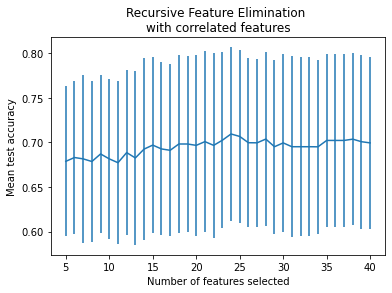

In [983]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [984]:
#Model4 （len(columns) descriptors）
Model4_clf=LogisticRegression(C=study.best_params['logreg_c'],max_iter=study.best_params['max_iter'],solver='liblinear',random_state=0)
#Model4
Model4=Model_results(Model4_clf,X_LR,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.709810,0.012400
Accuracy_train,0.746103,0.003818
F1 Score,0.779298,0.008767
Precision,0.664975,0.011021
Recall,0.950714,0.010234
Roc_auc,0.840527,0.015997


In [985]:
Model4_clf=Model4_clf.fit(X_LR, y)
#Saving the final model
joblib.dump(Model4_clf, './Models/LogReg.pkl')
LogReg= joblib.load(filename='./Models/LogReg.pkl')

In [986]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./Original data/X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_lr.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

,MATS3p,SM10_AEA(dm),GATS7s,F07[N-O],VE1sign_Dz(v),VE3sign_D/Dt,P_VSA_charge_4,CATS2D_09_DA,B09[O-O],CATS2D_06_DL,...,H-052,F05[N-N],SpDiam_AEA(ed),VE1sign_B(p),F10[O-O],nN(CO)2,CATS2D_03_DL,GATS6i,CATS2D_05_DA,C-016
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.148099,0.279629,0.937287,-0.166667,0.401550,0.672502,0.359389,0.0,0.0,0.25,...,1.0,0.0,0.210290,0.063176,0.0,0.0,0.0,-0.520914,-0.166667,0.0
13463,0.167609,0.382490,0.371194,0.166667,0.297744,0.433674,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.243399,0.003349,0.0,0.0,0.0,0.173585,0.166667,0.0
39148,0.082452,0.442684,0.247689,0.500000,0.278206,0.618221,0.000000,0.4,0.0,0.00,...,0.0,0.0,0.283448,-0.032536,0.0,0.0,0.0,-0.901637,0.500000,0.0
56328,0.345941,0.338437,0.498540,0.166667,0.422186,0.448300,0.000000,0.4,0.0,0.00,...,0.0,0.0,0.213133,-0.036314,0.0,0.0,0.5,0.422220,0.000000,0.0
67358,0.202511,0.471826,0.577994,0.500000,0.354301,0.414307,0.000000,0.4,0.0,0.00,...,0.0,0.0,0.297216,0.352888,0.0,0.0,0.0,0.090504,0.500000,0.0


In [987]:
Predicted_data=pd.DataFrame(LogReg.predict_proba(X_test),columns=['Probability of not gelable','Probability of gelable'])

Predicted_data

,Probability of not gelable,Probability of gelable
0,0.570452,0.429548
1,0.505964,0.494036
2,0.503674,0.496326
3,0.500454,0.499546
4,0.464747,0.535253
...,...,...
7252,0.482198,0.517802
7253,0.403192,0.596808
7254,0.487210,0.512790
7255,0.477910,0.522090


In [988]:
#Predicted results
Predicted_data=pd.DataFrame(LogReg.predict_proba(X_test),columns=['Probability of not gelable','Probability of gelable'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of gelable" , inplace=True, ascending=False)
Predicted_data.to_csv("./Results/LR_predict_data.csv",sep=',')
Predicted_data.head()

,Probability of not gelable,Probability of gelable
cid,,
445132,0.316696,0.683304
92252368,0.319758,0.680242
21826754,0.319758,0.680242
131876227,0.323628,0.676372
293725,0.340278,0.659722


In [989]:
row_num1 = Predicted_data.index.get_loc(135518164)
row_num2 = Predicted_data.index.get_loc(135763231)
row_num3 = Predicted_data.index.get_loc(135407175)
row_num_all=[row_num1,row_num2,row_num3]
row_num_all

[459, 568, 471]

426

In [990]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./Results/LR_model_data.csv",sep=',')
Model_data.columns = [['LogisticRegression']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./Results/LR_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         LogisticRegression                                          \
Model                     Model 1             Model 2             Model 3   
Values                       Mean        Se      Mean        Se      Mean   
Accuracy_test            0.648095  0.015986  0.682952  0.015215  0.702667   
Accuracy_train           0.963346  0.003934  0.857093  0.003845  0.731316   
F1 Score                 0.668427  0.018017  0.707642  0.015002  0.777069   
Precision                0.673742  0.017943  0.706392  0.017167  0.655992   
Recall                   0.687857  0.025052  0.733214  0.022613  0.962857   
Roc_auc                  0.670417  0.018521  0.802772  0.015816  0.806556   

Method                                        
Model                      Model 4            
Values                Se      Mean        Se  
Accuracy_test   0.011735  0.709810  0.012400  
Accuracy_train  0.003572  0.746103  0.003818  
F1 Score        0.008116  0.779298  0.008767  
Precision       0.010239  0.664975  0.011021  
Recall          0.009818  0.950714  0.010234  
Roc_auc         0.016848  0.840527  0.015997

In [991]:
#Feature Importance
LogReg= joblib.load(filename='./Models/LogReg.pkl')
result = permutation_importance(
    LogReg, X_LR, y, n_repeats=1000, random_state=0, n_jobs=2)
clf2_importances = pd.Series(result.importances_mean, index= columns)
importances_mean=pd.DataFrame(clf2_importances, index=columns)
importances_std=pd.DataFrame(result.importances_std, index=columns)
importances_se=pd.DataFrame(result.importances_std/math.sqrt(10), index=columns)
importances_=pd.concat([importances_mean,importances_std,importances_se],axis=1)
importances_.columns=["mean","std","se"]
Feature_importance=importances_.sort_values(by="mean",ascending=True)
Feature_importance.columns=[['LogisticRegression']*3,["mean","std","se"]]
Feature_importance.columns.names=['Method','Values']
Feature_importance.to_csv('./Results/LR_feature_importance.csv',encoding='utf-8')
Feature_importance

Method         LogisticRegression                    
Values                       mean       std        se
CATS2D_09_DA            -0.015887  0.013983  0.004422
GATS7s                  -0.013592  0.010908  0.003449
SpMAD_EA(ri)            -0.012169  0.010832  0.003425
GATS6i                  -0.007761  0.009421  0.002979
VE1sign_B(p)            -0.007521  0.009394  0.002971
SpDiam_AEA(ed)          -0.005972  0.012441  0.003934
SM10_AEA(dm)            -0.005310  0.013098  0.004142
VE3sign_D/Dt            -0.005155  0.015621  0.004940
MATS3p                  -0.004211  0.009548  0.003019
F10[O-O]                -0.001662  0.010177  0.003218
P_VSA_charge_4          -0.001352  0.016574  0.005241
F05[N-N]                -0.000972  0.016523  0.005225
CATS2D_05_DL            -0.000662  0.015727  0.004973
VE1sign_Dz(v)            0.000127  0.009289  0.002937
F07[N-O]                 0.000930  0.014890  0.004709
C-016                    0.004451  0.021665  0.006851
CATS2D_05_DA             0.005845  0.009372  0.002964
CATS2D_04_AA             0.005859  0.008127  0.002570
nN(CO)2                  0.009056  0.015807  0.004999
CATS2D_03_DL             0.010549  0.010928  0.003456
H-052                    0.013507  0.020280  0.006413
P_VSA_charge_7           0.014268  0.015878  0.005021
B09[O-O]                 0.017549  0.026007  0.008224
CATS2D_06_DL             0.018169  0.016557  0.005236